In [ ]:
!pip install torch pandas matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
url = "https://gist.githubusercontent.com/CharlieRay668/b9d63bcc7e1b9f7f3a078fbbc03c6823/raw/4b6c1c62d50a6e24dcee6f8f891d437e29ff3ec4/cpquantstockdata.csv"

df = pd.read_csv(url, header=[0, 1], index_col=0)["MSFT"]
df

,close,high,low,trades,open,volume,volume weighted
time,,,,,,,
2017-01-03 05:00:00,62.58,62.84,62.125,115077,62.80,23692973,62.471587
2017-01-04 05:00:00,62.30,62.75,62.120,112255,62.46,24383698,62.309944
2017-01-05 05:00:00,62.30,62.66,62.030,117581,62.18,27927285,62.345968
2017-01-06 05:00:00,62.84,63.15,62.040,111899,62.35,22359924,62.787132
2017-01-09 05:00:00,62.64,63.08,62.540,98825,62.67,24621963,62.726351
...,...,...,...,...,...,...,...
2024-03-04 05:00:00,414.92,417.35,412.320,397492,413.44,17595956,415.133115
2024-03-05 05:00:00,402.65,414.25,400.640,538264,413.96,26923077,403.929173
2024-03-06 05:00:00,402.09,405.16,398.390,449330,402.97,22344149,402.228118


In [ ]:
# Calculate tick bars
tick_bars = []
sample_size = 1000
t = 0
prev_t = 0
ticks = df
for index, row in ticks.iterrows():
  if t-prev_t > sample_size:
    tick_bars.append({
        "open": ticks.iloc[prev_t]["price"],
        "high": max(ticks.iloc[prev_t:t]["price"]),
        "low": min(ticks.iloc[prev_t:t]["price"]),
        "close": ticks.iloc[t]["price"],
        "volume": sum(ticks.iloc[prev_t:t]["size"]),
        "timestamp": ticks.iloc[prev_t]["time"],
    })
    prev_t = t
  t += 1
tick_bars = pd.DataFrame(tick_bars)
tick_bars

KeyError: 'price'

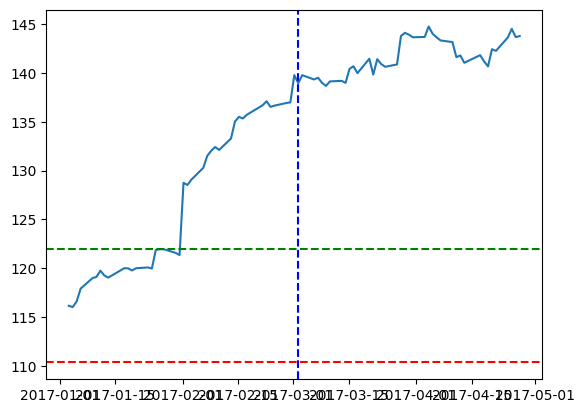

In [ ]:
import datetime as dt
import numpy as np
aapl_df = df["AAPL"]
# Convert index to datetime
pd.options.mode.chained_assignment = None  # default='warn'
aapl_df.index = pd.to_datetime(aapl_df.index)
datapoints = []
holding_time = 40
for index, row in aapl_df.iterrows():
  if index+dt.timedelta(days=holding_time) > aapl_df.index[-1]:
    break
  datapoints.append({"index": index, "prices": aapl_df[index:index+dt.timedelta(days=holding_time)]["close"].to_list()})

def generate_signals(datapoints):
  signals = []
  for datapoint in datapoints:
    signal = 0
    start_price = datapoint["prices"][0]
    for price in datapoint["prices"][1:]:
      if price > start_price*1.05:
        signal = 1
        break
      elif price < start_price*0.95:
        signal = -1
        break
    signals.append({"index":datapoint["index"], "signal":signal})
  return signals

signals = generate_signals(datapoints)
aapl_df["signal"] = np.nan
for signal in signals:
  aapl_df["signal"][signal["index"]] = signal["signal"]

start_price = aapl_df.iloc[0]["close"]
plt.plot(aapl_df.iloc[:80]["close"])
# plot vertical line at 40 days
plt.axvline(x=aapl_df.index[40], color='b', linestyle='--')
# plot green horizontal line at 1.05*start_price and red horizontal line at 0.95*start_price
plt.axhline(y=start_price*1.05, color='g', linestyle='--')
plt.axhline(y=start_price*0.95, color='r', linestyle='--')

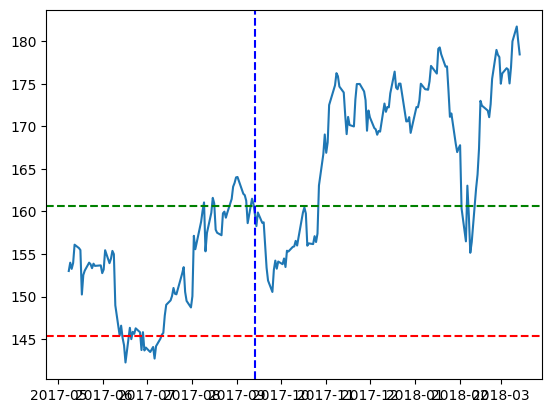

In [ ]:
desired_signal = -1
start = aapl_df[aapl_df["signal"] == desired_signal].iloc[0]
middle = aapl_df[aapl_df["signal"] == desired_signal].iloc[40]
end = aapl_df[aapl_df["signal"] == desired_signal].iloc[80]
start_price = start["close"]
plt.plot(aapl_df.loc[start.name:end.name]["close"])
# plot vertical line at 40 days
plt.axvline(x=middle.name, color='b', linestyle='--')
# plot green horizontal line at 1.05*start_price and red horizontal line at 0.95*start_price
plt.axhline(y=start_price*1.05, color='g', linestyle='--')
plt.axhline(y=start_price*0.95, color='r', linestyle='--')

In [ ]:
i
# IGNORE, BROKEN CODE


# Select features and target
aapl_df = df["AAPL"][:1000]
features = aapl_df[['open', 'high', 'low', 'volume']]  # You can choose what features to include
target = aapl_df['close']

# Normalize the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

# Split the data into training and test sets
split = int(0.8 * len(aapl_df))
X_train, X_test = features_scaled[:split], features_scaled[split:]
y_train, y_test = target_scaled[:split], target_scaled[split:]

In [ ]:
import torch

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

seq_length = 10  # Number of time steps to look back
X_train_seq, y_train_seq = create_sequences(X_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, seq_length)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class StockTransformer(nn.Module):
    def __init__(self, input_dim, seq_length, nhead, num_layers, dim_feedforward, num_classes=1):
        super(StockTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, dim_feedforward)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(seq_length * dim_feedforward, num_classes)

    def forward(self, src):
        embedded = F.relu(self.embedding(src))
        transformer_out = self.transformer_encoder(embedded)
        output = self.fc(transformer_out.flatten(start_dim=1))
        return output

model = StockTransformer(input_dim=X_train_seq.shape[-1], seq_length=seq_length, nhead=8, num_layers=3, dim_feedforward=256)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 60
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    with autocast():
        output = model(X_train_seq)
        loss = criterion(output, y_train_seq)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([789, 4])) that is different to the input size (torch.Size([789, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.8751459717750549
Epoch 5, Loss: 2.276914358139038
Epoch 10, Loss: 0.5074561238288879
Epoch 15, Loss: 0.37266144156455994
Epoch 20, Loss: 0.12459311634302139
Epoch 25, Loss: 0.03963778540492058
Epoch 30, Loss: 0.05738326907157898
Epoch 35, Loss: 0.0704481229186058
Epoch 40, Loss: 0.06380783766508102
Epoch 45, Loss: 0.055143896490335464
Epoch 50, Loss: 0.04939054325222969
Epoch 55, Loss: 0.04164460673928261


In [ ]:
model.eval()
predicted_stock_prices = model(X_test_seq)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices.detach().numpy())
actual_stock_prices = scaler.inverse_transform(y_test_seq.detach().numpy())

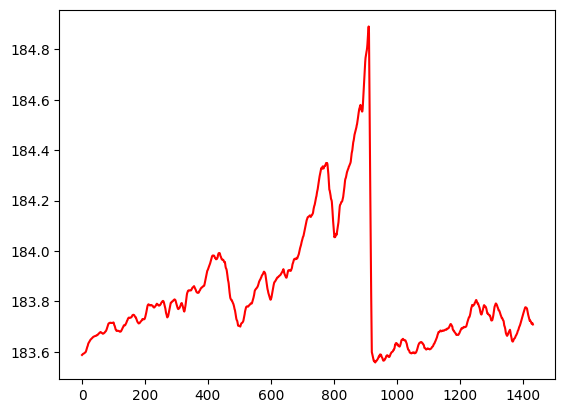

In [ ]:
predicted_stock_prices = model(X_train_seq)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices.detach().numpy())
plt.plot(predicted_stock_prices, color="red")
# plt.plot(actual_stock_prices, color="blue")
# print(actual_stock_prices)

StockTransformer(
  (embedding): Linear(in_features=4, out_features=512, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=5120, out_features=1, bias=True)
)